## Imports and Constants

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from typing import Dict, List, Set, Tuple

In [2]:
TICK_SIZE = 18
XLABEL = 25
YLABEL = 20
TITLE_SIZE = 28

## Parsing

In [3]:
def parse_result(res):
    _, res_str = res.split(": ")
    return int(res_str)

def parse_line(line):
    # print(line)
    param, results = line.split(" - ")
    mean_res, sd_res = results.split(", ")
    return int(param), parse_result(mean_res), sd_res.rstrip()

def parse_file(name):
    with open(name, "r") as f:
        lines = f.readlines()
        idx = 0
        results = {}
        while (idx < len(lines)):
            result_name = lines[idx].rstrip()
            idx += 1
            result = {}
            while (True):
                result_line = lines[idx]
                param, mean, sd = parse_line(result_line)
                
                result[param] = mean

                idx += 2
                if lines[idx].rstrip() == ";;":
                    idx += 1
                    break

            results[result_name] = result

        return results


## Preprocessing and Utils

In [4]:
regex_params = [1000, 10000, 100000, 500000, 1000000, 5000000, 10000000, 25000000]
knucl_params = [1000, 10000, 50000, 100000, 500000, 1000000, 2500000, 5000000]

def replace_params(key, params, all_results):
    if key in all_results:
        results = all_results[key]
        results = {params[k]: v for k, v in results.items()}
        all_results[key] = results

def update_params(results):
    to_update = {"regexredux":regex_params, "knucleotide":knucl_params}
    for protocol, params in to_update.items():
        replace_params(f"{protocol}-scribble", params, results)
        replace_params(f"{protocol}-base", params, results)

def result_points(results):
    sorted_keys = sorted(list(results.keys()))
    y_values = [results[key] for key in sorted_keys]
    return sorted_keys, y_values

## Plot functions

### Utils

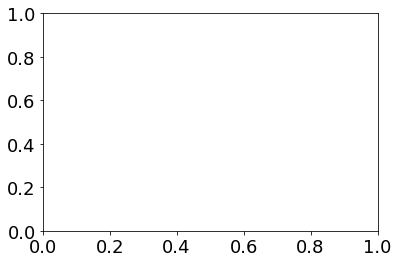

In [5]:
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)

def gen_baseline(x):
    baseline = np.linspace(x[0], x[-1], 1000 )
    return baseline

def get_ratios(base, scr):
    ratios = np.array(base) / np.array(scr)
    return ratios

### Plot Quicksort

In [6]:
incr = 500
start = 500

# traces_to_plot = {500, 1500, 3500, 5500, 9500}

traces_to_plot = {1500, 3500, 5500, 6500, 8500}


def quicksort_trace_label(threshold: int):
    return f"T={threshold}"

def plot_all(x, results, baseline):
    plt.plot(baseline, baseline / baseline, linestyle="dashed", color="green", label="baseline")
    value = start
    for ratios in results:
        plt.plot(x, ratios, label=f"T={value}")
        value += incr
    # plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", prop={'size': TICK_SIZE})
    plt.legend(bbox_to_anchor=(-1, 0.5), loc="center left", prop={'size': TICK_SIZE})
    plt.xlabel("Array size", fontsize=XLABEL)
    plt.xticks(fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    # plt.ylabel("Relative Ratio", fontsize=15)
    plt.title("quicksort", fontdict={"fontsize":TITLE_SIZE, "fontweight":"bold"})
    plt.savefig(f"quicksort_thresholds.png", bbox_inches='tight')
    plt.show()

def plot_quicksort(filename):
    all_results = {}
    for i in range(start, 10001, incr):
        if i not in traces_to_plot:
            continue
        
        benchmark_results = parse_file(f"{filename}{i}.txt")
        x, scribble_results = result_points(benchmark_results["quicksort-scribble"])
        _, base_results = result_points(benchmark_results["quicksort-base"])
        print(i, base_results[0], base_results[-1])
        ratios = get_ratios(base_results, scribble_results)
        all_results[quicksort_trace_label(i)] = ratios[:]
    baseline = gen_baseline(x[:])
    # plot_all(x[:], all_results, baseline)
    plot_multiple_traces(x[:], all_results, baseline, "quicksort", "Array size")


np.seterr("raise")
# plot_quicksort("benchmark-results")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Plot graphs one by one

In [7]:
trace_labels = {"fannkuch": "fannkuch", 
          "primesieve": "bounded prime sieve", 
          "knucleotide": "k-nucleotide", 
          "regexredux": "regex-redux", 
          "spectralnorm": "spectral-norm",
          "quicksort": "quicksort",
          "boundedfibonacci": "bounded fib"}
labels = {"fannkuch": "Permutation size", 
          "primesieve": "Upper bound", 
          "knucleotide": "Sequence length", 
          "regexredux": "Sequence length", 
          "spectralnorm": "Num Iterations",
          "quicksort": "Array size",
          "boundedfibonacci": "Nth term"}

def plot_single_graph(x, scr, base, label, trace_label):
    np.seterr("raise")
    baseline = np.linspace(x[0], x[-1], 1000)
    plt.plot(baseline, baseline / baseline, linestyle="dashed", color="green", label="baseline")
    ratios = np.array(base) / np.array(scr)
    plt.xticks(fontsize=TICK_SIZE)
    # plt.yticks(ticks=[0.2, 0.4, 0.6, 0.8, 1.0, 1.2], fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    plt.ylim((0.1, 1.4))
    plt.plot(x, ratios, label=trace_label)
    
    plt.title(trace_label, fontdict={"fontsize":TITLE_SIZE, "fontweight":"bold"})
    plt.xlabel(label, fontsize=XLABEL)
    # plt.ylabel("Relative Ratio", fontsize=YLABEL)

def y_min_max(results, start=None, end=None):
    y_max = 1.0
    y_min = 1.0
    if start is None:
        start_idx = 0
    else:
        start_idx = start
    for protocol in trace_labels.keys():
        scribble_name = f"{protocol}-scribble"
        base_name = f"{protocol}-base"
        if scribble_name not in results:
            continue
        x, scribble_results = result_points(results[scribble_name])
        _, base_results = result_points(results[base_name])
        if end is None:
            end_idx = len(scribble_results)
        else:
            end_idx = end
        ratios = (np.array(base_results[start:end]) / np.array(scribble_results[start:end]))[start_idx:end_idx]
        y_min = min(y_min, min(ratios))
        y_max = max(y_max, max(ratios))
    return y_min * 0.95, y_max *1.05

def plot_with_labels(results, start=None, end=None, y_lim=None):
    idx=0
    if start is None:
        start_idx = 0
    else:
        start_idx = start
    if y_lim is None:
        y_min, y_max = y_min_max(results, start, end)
        y_min *= 0.99
        y_max *= 1.01
    else:
        y_min, y_max = y_lim
    for protocol in trace_labels.keys():
        scribble_name = f"{protocol}-scribble"
        base_name = f"{protocol}-base"
        if scribble_name not in results:
            print(scribble_name)
            continue

        print(protocol)

        x, scribble_results = result_points(results[scribble_name])
        _, base_results = result_points(results[base_name])
        if end is None:
            end_idx = len(scribble_results)
        else:
            end_idx = end
        plt.figure(figsize=(6, 3))
        plot_single_graph(x[start:end], scribble_results[start:end], base_results[start:end], label=labels[protocol], trace_label=trace_labels[protocol])



        idx += 1

        plt.savefig(f"performance{idx}.png", bbox_inches='tight')
        plt.show()

    

### Plot Overhead Breakdown

Protocols bounded prime sieve and bounded fibonacci

In [8]:


sieve_baselines_trace_info = {"primesieve-no-callbacks":"no callbacks",
                      "primesieve-opt-invitations": "opt invitations",
                      "primesieve-optimised": "fully optimised"}
sieve_scribble_trace_info = "primesieve-scribble"

fib_baselines_trace_info = {"bfib-no-callbacks":"no callbacks",
                      "bfib-opt-invitations": "opt invitations",
                      "bfib-opt-labelled-msgs": "opt labelled msgs",
                      "bfib-optimised": "fully optimised"}
fib_scribble_trace_info = "bfib-scribble"

def plot_multiple_traces(x: List[float], results:Dict[str, List[float]], baseline: List[float], title="", xlabel=""):
    # List[float] => np.array(float64)
    for trace_label, ratios in results.items():
        plt.plot(x, ratios, label=trace_label)
    plt.plot(baseline, baseline / baseline, linestyle="dashed", color="green", label="baseline")
    plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", prop={'size': TICK_SIZE})
    plt.xlabel(xlabel, fontsize=XLABEL)
    plt.xticks(fontsize=TICK_SIZE)
    # plt.ylabel("Relative Ratio", fontsize=YLABEL)
    plt.title(title, fontdict={"fontsize":TITLE_SIZE, "fontweight":"bold"})
    plt.savefig(f"{title}.png", bbox_inches='tight')
    plt.show()

def plot_overheads(scr_trace: str, baseline_traces: Dict[str, str], title: str="", xlabel:str=""):
    all_results = {}

    benchmark_results = parse_file(f"{scr_trace}.txt")
    x, scribble_results = result_points(benchmark_results[scr_trace])

    for trace_name, trace_label in baseline_traces.items():
        benchmark_results = parse_file(f"{trace_name}.txt")
        x, base_results = result_points(benchmark_results[trace_name])
        ratios = get_ratios(base_results, scribble_results)
        all_results[trace_label] = ratios[:]
    baseline = gen_baseline(x[:])
    plot_multiple_traces(x[:], all_results, baseline, title, xlabel)

def plot_primesieve_overheads():
    plot_overheads(sieve_scribble_trace_info, sieve_baselines_trace_info, "bounded prime sieve", "Upper Bound")

def plot_bfib_overheads():
    plot_overheads(fib_scribble_trace_info, fib_baselines_trace_info, "bounded fibonacci", "Nth Term")


## Generate plots

1500 47 1332048
3500 47 1288433
5500 47 1294453
6500 47 1273581
8500 46 1266349


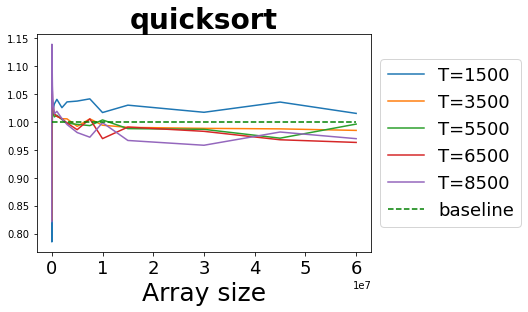

fannkuch


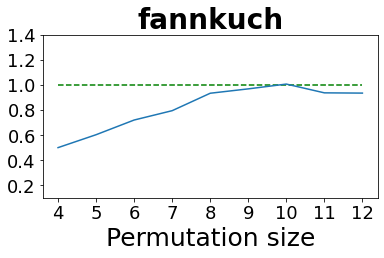

primesieve


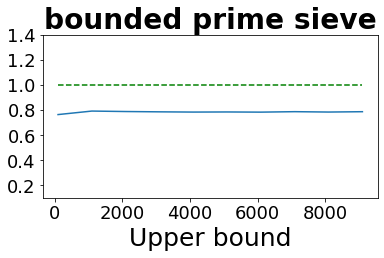

knucleotide


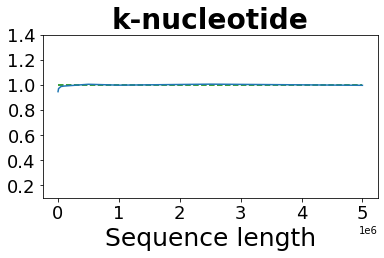

regexredux


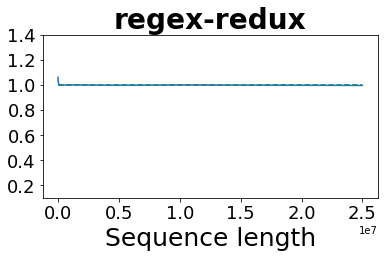

spectralnorm


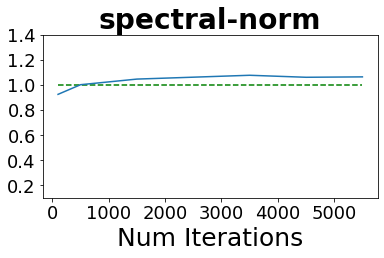

quicksort-scribble
boundedfibonacci


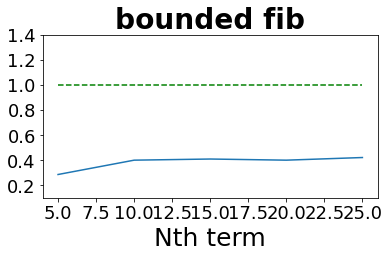

In [9]:
# new-bm/
plot_quicksort("benchmark-results")
# benchmark_results = parse_file("new-results.txt")
# update_params(benchmark_results)
# plot_with_labels(benchmark_results)
benchmark_results = parse_file("benchmark-results.txt")
update_params(benchmark_results)
plot_with_labels(benchmark_results)
#plot_primesieve_overheads()
#plot_bfib_overheads()

# New section

In [10]:
print(result_points(benchmark_results))
protocols, results = result_points(benchmark_results)
for p, res in zip(protocols, results):
    print(p, res[min(res.keys())], res[max(res.keys())])

(['boundedfibonacci-base', 'boundedfibonacci-scribble', 'fannkuch-base', 'fannkuch-scribble', 'knucleotide-base', 'knucleotide-scribble', 'primesieve-base', 'primesieve-scribble', 'regexredux-base', 'regexredux-scribble', 'spectralnorm-base', 'spectralnorm-scribble'], [{5: 2, 10: 6, 15: 9, 20: 12, 25: 16}, {5: 7, 10: 15, 15: 22, 20: 30, 25: 38}, {6: 270, 7: 638, 8: 2078, 11: 397391, 12: 5471832, 4: 7, 5: 41, 9: 14669, 10: 49933}, {7: 803, 10: 49607, 11: 424279, 12: 5854755, 4: 14, 5: 68, 6: 375, 8: 2226, 9: 15149}, {500000: 147539, 1000000: 269369, 2500000: 635413, 5000000: 1205350, 1000: 844, 10000: 6604, 50000: 31478, 100000: 44664}, {2500000: 631698, 5000000: 1209250, 1000: 892, 10000: 6803, 50000: 31886, 100000: 45078, 500000: 146807, 1000000: 269930}, {4100: 26656, 5100: 38591, 7100: 68244, 8100: 85198, 2100: 8626, 3100: 16501, 6100: 52236, 9100: 104356, 100: 71, 1100: 2997}, {100: 93, 3100: 21013, 4100: 34028, 8100: 108730, 9100: 132710, 1100: 3787, 2100: 10951, 5100: 49207, 6100